In [1]:
# 1. ─── Imports & Constants ──────────────────────────────────────────────────
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image as kp_image

from sklearn.metrics import classification_report, confusion_matrix

# Adjust these if your data folder is named differently
DATA_DIR    = "data"  
CLASS_NAMES = ["plastic", "metal", "glass", "paper", "cardboard", "trash"]
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32
EPOCHS      = 20


/Users/raman/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# 2. ─── Cleanup: Remove any non‑image or corrupted files ────────────────────
valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}
bad_files = []

for root, _, files in os.walk(DATA_DIR):
    for fname in files:
        path = os.path.join(root, fname)
        ext = os.path.splitext(fname)[1].lower()
        # wrong extension?
        if ext not in valid_exts:
            bad_files.append(path)
            continue
        # corrupted image?
        try:
            img = Image.open(path)
            img.verify()
        except:
            bad_files.append(path)

for f in bad_files:
    os.remove(f)

print(f"Removed {len(bad_files)} invalid files.")


Removed 0 invalid files.


In [3]:
# 3. ─── Inspect Folder Counts ────────────────────────────────────────────────
for split in ["train", "val", "test"]:
    counts = {cls: len(os.listdir(os.path.join(DATA_DIR, split, cls)))
              if os.path.exists(os.path.join(DATA_DIR, split, cls)) else 0
              for cls in CLASS_NAMES}
    print(f"{split:>5}:", counts)


train: {'plastic': 18, 'metal': 410, 'glass': 501, 'paper': 1680, 'cardboard': 60, 'trash': 947}
  val: {'plastic': 18, 'metal': 410, 'glass': 501, 'paper': 1680, 'cardboard': 60, 'trash': 947}
 test: {'plastic': 18, 'metal': 410, 'glass': 501, 'paper': 1680, 'cardboard': 60, 'trash': 947}


In [4]:
# 4. ─── Load Datasets ────────────────────────────────────────────────────────
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    labels="inferred", label_mode="int", class_names=CLASS_NAMES,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    labels="inferred", label_mode="int", class_names=CLASS_NAMES,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    labels="inferred", label_mode="int", class_names=CLASS_NAMES,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)


Found 3616 files belonging to 6 classes.
Found 3616 files belonging to 6 classes.
Found 3616 files belonging to 6 classes.


2025-06-20 22:32:29.268798: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


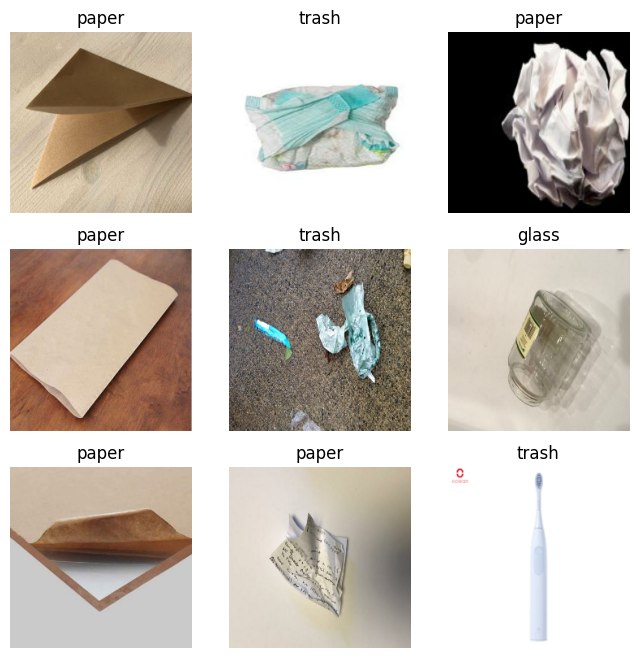

In [5]:
# 5. ─── (Optional) Visualize a Batch ────────────────────────────────────────
plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(CLASS_NAMES[labels[i]])
        ax.axis("off")
plt.show()


In [6]:
# 6. ─── Data Augmentation Pipeline ──────────────────────────────────────────
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Rescaling(1./255)
])


In [7]:
# 7. ─── Build & Compile the Model ───────────────────────────────────────────
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(len(CLASS_NAMES), activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
import tensorflow as tf
import os

bad = []
for split in ["train","val","test"]:
    folder = os.path.join(DATA_DIR, split)
    for root, _, files in os.walk(folder):
        for fname in files:
            path = os.path.join(root, fname)
            try:
                # Try reading & decoding the file
                raw = tf.io.read_file(path)
                _   = tf.io.decode_image(raw)
            except Exception as e:
                bad.append(path)

print("Bad files found:", len(bad))
for p in bad:
    print(" ", p)


2025-06-20 22:42:33.653342: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
2025-06-20 22:42:42.525489: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Unknown image file format. One of JPEG, PNG, GIF, BMP required.


Bad files found: 10
  data/train/paper/paper_2784.jpg
  data/train/paper/paper_1678.jpg
  data/train/paper/paper_3119.jpg
  data/val/paper/paper_2784.jpg
  data/val/paper/paper_1678.jpg
  data/val/paper/paper_3119.jpg
  data/test/.DS_Store
  data/test/paper/paper_2784.jpg
  data/test/paper/paper_1678.jpg
  data/test/paper/paper_3119.jpg


In [10]:
import os

bad_paths = [
    "data/train/paper/paper_2784.jpg",
    "data/train/paper/paper_1678.jpg",
    "data/train/paper/paper_3119.jpg",
    "data/val/paper/paper_2784.jpg",
    "data/val/paper/paper_1678.jpg",
    "data/val/paper/paper_3119.jpg",
    "data/test/.DS_Store",
    "data/test/paper/paper_2784.jpg",
    "data/test/paper/paper_1678.jpg",
    "data/test/paper/paper_3119.jpg"
]

deleted = 0
for p in bad_paths:
    if os.path.exists(p):
        os.remove(p)
        deleted += 1
print(f"Deleted {deleted} bad files.")


Deleted 10 bad files.


In [11]:
import tensorflow as tf

still_bad = []
for split in ["train","val","test"]:
    for root, _, files in os.walk(os.path.join(DATA_DIR, split)):
        for fname in files:
            path = os.path.join(root, fname)
            try:
                raw = tf.io.read_file(path)
                _   = tf.io.decode_image(raw)
            except:
                still_bad.append(path)

print("Still failing to decode:", still_bad)


Still failing to decode: []


In [12]:
import tensorflow as tf
from tensorflow.keras import layers

# 1) Reload datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    labels="inferred", label_mode="int", class_names=CLASS_NAMES,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    labels="inferred", label_mode="int", class_names=CLASS_NAMES,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)

# 2) (Re)build model components if needed
#    (Assuming data_augmentation, base_model, and model are already defined;
#     otherwise re-run their definition cells.)

# 3) Train
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
]
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)


Found 3613 files belonging to 6 classes.
Found 3613 files belonging to 6 classes.
Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.4534 - loss: 1.4143

113/113 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.4535 - loss: 1.4140 - val_accuracy: 0.4642 - val_loss: 1.3331
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.4722 - loss: 1.3358

113/113 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.4721 - loss: 1.3358 - val_accuracy: 0.4642 - val_loss: 1.3254
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.4684 - loss: 1.3350

113/113 ━━━━━━━━━━━━━━━━━━━━ 76s 666ms/step - accuracy: 0.4684 - loss: 1.3350 - val_accuracy: 0.4642 - val_loss: 1.3236
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.4665 - loss: 1.3468

113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 547ms/step - accuracy: 0.4665 - loss: 1.3467 - val_accuracy: 0.4642 - val_loss: 1.3229
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.4723 - loss: 1.3270

113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 557ms/step - accuracy: 0.4722 - loss: 1.3270 - val_accuracy: 0.4642 - val_loss: 1.3226
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.4631 - loss: 1.3483

113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 555ms/step - accuracy: 0.4631 - loss: 1.3481 - val_accuracy: 0.4642 - val_loss: 1.3224
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 554ms/step - accuracy: 0.4682 - loss: 1.3347 - val_accuracy: 0.4642 - val_loss: 1.3228
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 552ms/step - accuracy: 0.4708 - loss: 1.3377 - val_accuracy: 0.4642 - val_loss: 1.3224
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 60s 536ms/step - accuracy: 0.4675 - loss: 1.3391 - val_accuracy: 0.4642 - val_loss: 1.3227


In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 3613 files belonging to 6 classes.


In [16]:
loss, acc = model.evaluate(test_ds)
print(f"Test accuracy: {acc:.2%}")


113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 268ms/step - accuracy: 0.4643 - loss: 1.3103
Test accuracy: 46.42%


In [17]:
# 9. ─── Evaluate on Test Set ─────────────────────────────────────────────────
loss, acc = model.evaluate(test_ds)
print(f"Test accuracy: {acc:.2%}")

y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print(classification_report(
    y_true, y_pred,
    labels=list(range(len(CLASS_NAMES))),
    target_names=CLASS_NAMES,
    zero_division=0
))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_NAMES))))
print("Confusion Matrix:\n", cm)


113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 260ms/step - accuracy: 0.4679 - loss: 1.3018
Test accuracy: 46.42%
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 266ms/step
              precision    recall  f1-score   support

     plastic       0.00      0.00      0.00        18
       metal       0.00      0.00      0.00       410
       glass       0.00      0.00      0.00       501
       paper       0.46      1.00      0.63      1677
   cardboard       0.00      0.00      0.00        60
       trash       0.00      0.00      0.00       947

    accuracy                           0.46      3613
   macro avg       0.08      0.17      0.11      3613
weighted avg       0.22      0.46      0.29      3613

Confusion Matrix:
 [[   0    0    0   18    0    0]
 [   0    0    0  410    0    0]
 [   0    0    0  501    0    0]
 [   0    0    0 1677    0    0]
 [   0    0    0   60    0    0]
 [   0    0    0  947    0    0]]


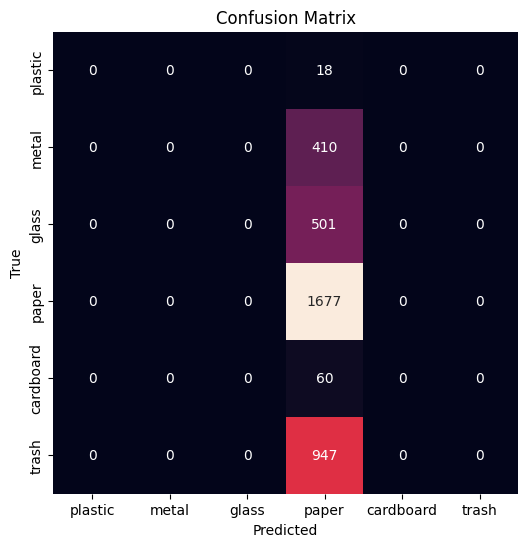

In [18]:
# 10. ─── Plot Confusion Matrix ───────────────────────────────────────────────
import seaborn as sns

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [19]:
# 11. ─── Single‑Image Inference & Save Model ─────────────────────────────────
def predict_image(path):
    img = kp_image.load_img(path, target_size=IMG_SIZE)
    x   = kp_image.img_to_array(img) / 255.0
    x   = np.expand_dims(x, axis=0)
    preds = model.predict(x)[0]
    idx   = np.argmax(preds)
    return CLASS_NAMES[idx], preds[idx]

# Example:
label, conf = predict_image("data/test/glass/glass20.jpg")
print(f"Prediction: {label} ({conf:.2%})")

model.save("waste_classifier_final.h5")
print("Saved model to waste_classifier_final.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


Prediction: paper (47.38%)
Saved model to waste_classifier_final.h5
